## Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 


### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Use a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 6](#step6): Write your Algorithm
* [Step 7](#step7): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

### Import Dog Dataset

In the code cell below, we import a dataset of dog images.  We populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

In [3]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('train')
valid_files, valid_targets = load_dataset('valid')
test_files, test_targets = load_dataset('test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### Import Human Dataset

In the code cell below, we import a dataset of human images, where the file paths are stored in the numpy array `human_files`.

In [4]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


---
<a id='step1'></a>
## Step 1: Detect Humans

We use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.

In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


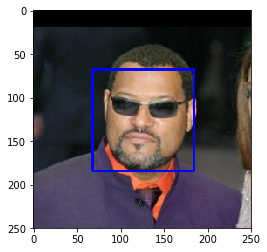

In [11]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[3])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [12]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 

Performance of the `face_detector` function is as follows:
* **99 %** of the first 100 human images have a detected human face (Wonderful .. !!).
* **12 %** of the first 100 dog images have a detected human face (Not up to the mark .. !!).

In [14]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]
# Do NOT modify the code above this line.

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
results_humans = []
results_dogs = []
for i in range(len(human_files_short)):
    results_humans.append(face_detector(human_files_short[i]))
    results_dogs.append(face_detector(dog_files_short[i]))
    
print('Human face is detected in {0:.0f} % of the total {1:.0f} human images'.format((np.sum(results_humans)/len(human_files_short))*100,len(human_files_short)))
print('Human face is detected in {0:.0f} % of the total {1:.0f} dog images'.format((np.sum(results_dogs)/len(dog_files_short))*100,len(dog_files_short)))

Human face is detected in 99 % of the total 100 human images
Human face is detected in 12 % of the total 100 dog images


__Question 2:__ This algorithmic choice necessitates that we communicate to the user that we accept human images only when they provide a clear view of a face (otherwise, we risk having unneccessarily frustrated users!). In your opinion, is this a reasonable expectation to pose on the user? If not, can you think of a way to detect humans in images that does not necessitate an image with a clearly presented face?

__Answer:__

The face detector worked well with the small dataset of 100 human images in our case. However as mentioned, it may not work well if an image with a blur face is supplied. Communicating with the users that clear view of face is required for better results can be one solution. However, following options can be attempted before communicating with the users to alleviate the necessity of images with a clear view of human face:

* *Preprocessing of images* can be implemented to adjust various parameters (for e.g., *color brightness* and *color contrast*) which might help to separate the human face from rest of the image, ultimately providing better results in face detection.
* *Convolutional neural networks* can be attempted as the architecture directly harnesses features from the images unlike the predefined Haar features in cascade classifier, overall increasing the probability of improved face detection. 

We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on each of the datasets.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  Our first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [15]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

In [16]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function `preprocess_input`.  If you're curious, you can check the code for `preprocess_input` [here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [17]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

We use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [18]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

### (IMPLEMENTATION) Assess the Dog Detector

__Question 3:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 

Performance of the `dog_detector` function is as follows:
* **1 %** of the images in `human_files_short` have a detected dog (OK .. !!).
* **All** of the images `dog_files_short` have a detected dog (Awesome .. !!).

In [19]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.

results_humans_in_dogdetector = []
results_dogs_in_dogdetector = []
for i in range(len(human_files_short)):
    results_humans_in_dogdetector.append(dog_detector(human_files_short[i]))
    results_dogs_in_dogdetector.append(dog_detector(dog_files_short[i]))
    
print('Dog is detected in {0:.0f} % of the total {1:.0f} human images'.format((np.sum(results_humans_in_dogdetector)/len(human_files_short))*100,len(human_files_short)))
print('Dog is detected in {0:.0f} % of the total {1:.0f} dog images'.format((np.sum(results_dogs_in_dogdetector)/len(dog_files_short))*100,len(dog_files_short)))

Dog is detected in 1 % of the total 100 human images
Dog is detected in 100 % of the total 100 dog images


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 1%.  In Step 5 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

Be careful with adding too many trainable layers!  More parameters means longer training, which means you are more likely to need a GPU to accelerate the training process.  Thankfully, Keras provides a handy estimate of the time that each epoch is likely to take; you can extrapolate this estimate to figure out how long it will take for your algorithm to train. 

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun! 

### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [ ]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6680/6680 [03:20<00:00, 33.38it/s]


### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        model.summary()

           
__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  If you chose to use the hinted architecture above, describe why you think that CNN architecture should work well for the image classification task.

__Answer:__ 

The steps followed to achieve the final CNN architecture can be described as follows:

**Step - 1 : Convolutional and Pooling Layers**

Inspired from VGG architecture that uses repetitive combination of small convolutions and pooling layers, proposed CNN architecture uses *5 layers* of *3 by 3 convolutions* following by *2 by 2 max pooling layers*. At the end, a global average pooling layer is used rather than simply flattening the inputs from previous max pooling layer because it preserves the information while reducing the number of parameters significantly.

**Step - 2 : Dense Layers**

To convert the features into probability values, *2 dense layers* are used. The first layer uses *Relu* activation function and *dropout ratio of 30%* to avoid overfitting, while the last layer uses *softmax* activation function as the predicted value indicates the probability of the input being in a particular class. 

**Step - 3 : Number of epochs**

Initially, 10 epochs were tried to train the CNN which showed the accuracy of 4.67% with testing set. It was observed that value of loss function was constantly decreasing in each epoch. Therefore, training was attempted again using 25 epochs which *increased the testing accuracy more than twice*.

**Summary**

Proposed CNN architecrure provides **10.05% accuracy** with the testing dataset which is much higher than our goal of obtaining >1 % accuracy. Also, it surpassed the CNN suggested in hint which provides 2.51% accuracy in 10 epochs. Note that number of parameters is not too high in proposed CNN as compared to the suggested one which shows that computational efficiency is not compromised to achieve higher accuracy. More number of convolutional layers and filters were also attempted, however, the improvement in accuracy could not be justified with increase in training time.

In [76]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

### TODO: Define your architecture.
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu', input_shape=(224,224,3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(GlobalAveragePooling2D())
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(133, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_31 (Conv2D)           (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 112, 112, 16)      2320      
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 56, 56, 16)        0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 56, 56, 16)        2320      
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 28, 28, 16)        0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 28, 28, 16)        2320      
__________

### Compile the Model

In [77]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [78]:
from keras.callbacks import ModelCheckpoint  

### TODO: specify the number of epochs that you would like to use to train the model.

epochs = 25

### Do NOT modify the code below this line.

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/25
6680/6680 [==============================] - 23s 3ms/step - loss: 4.8855 - acc: 0.0091 - val_loss: 4.8711 - val_acc: 0.0108
Epoch 2/25
6680/6680 [==============================] - 21s 3ms/step - loss: 4.8710 - acc: 0.0082 - val_loss: 4.8714 - val_acc: 0.0108
Epoch 3/25
6680/6680 [==============================] - 21s 3ms/step - loss: 4.8552 - acc: 0.0117 - val_loss: 4.8248 - val_acc: 0.0192
Epoch 4/25
6680/6680 [==============================] - 21s 3ms/step - loss: 4.8074 - acc: 0.0154 - val_loss: 4.7613 - val_acc: 0.0204
Epoch 5/25
6680/6680 [==============================] - 21s 3ms/step - loss: 4.7537 - acc: 0.0193 - val_loss: 4.7099 - val_acc: 0.0216
Epoch 6/25
6680/6680 [==============================] - 21s 3ms/step - loss: 4.7243 - acc: 0.0187 - val_loss: 4.7215 - val_acc: 0.0216
Epoch 7/25
6680/6680 [==============================] - 21s 3ms/step - loss: 4.6979 - acc: 0.0211 - val_loss: 4.6900 - val_acc: 0.0168
Epoch 8/

### Load the Model with the Best Validation Loss

In [79]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### Test the Model

Try out your model on the test dataset of dog images.  Ensure that your test accuracy is greater than 1%.

In [80]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 10.0478%


---
<a id='step4'></a>
## Step 4: Use a CNN to Classify Dog Breeds

To reduce training time without sacrificing accuracy, we show you how to train a CNN using transfer learning.  In the following step, you will get a chance to use transfer learning to train your own CNN.

### Obtain Bottleneck Features

In [81]:
bottleneck_features = np.load('/data/bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

### Model Architecture

The model uses the the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to our model.  We only add a global average pooling layer and a fully connected layer, where the latter contains one node for each dog category and is equipped with a softmax.

In [82]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_11  (None, 512)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 133)               68229     
Total params: 68,229
Trainable params: 68,229
Non-trainable params: 0
_________________________________________________________________


### Compile the Model

In [83]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In [84]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 3s 494us/step - loss: 11.9898 - acc: 0.1260 - val_loss: 10.3793 - val_acc: 0.2216
Epoch 2/20
6680/6680 [==============================] - 3s 381us/step - loss: 9.5016 - acc: 0.2981 - val_loss: 9.4060 - val_acc: 0.2910
Epoch 3/20
6680/6680 [==============================] - 2s 372us/step - loss: 8.8289 - acc: 0.3778 - val_loss: 9.1925 - val_acc: 0.3257
Epoch 4/20
6680/6680 [==============================] - 2s 358us/step - loss: 8.6044 - acc: 0.4160 - val_loss: 9.0616 - val_acc: 0.3473
Epoch 5/20
6680/6680 [==============================] - 2s 348us/step - loss: 8.3758 - acc: 0.4331 - val_loss: 8.9183 - val_acc: 0.3653
Epoch 6/20
6680/6680 [==============================] - 2s 308us/step - loss: 8.1211 - acc: 0.4581 - val_loss: 8.6408 - val_acc: 0.3760
Epoch 7/20
6680/6680 [==============================] - 2s 336us/step - loss: 7.9825 - acc: 0.4762 - val_loss: 8.6160 - val_acc: 0.3784

### Load the Model with the Best Validation Loss

In [85]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

### Test the Model

Now, we can use the CNN to test how well it identifies breed within our test dataset of dog images.  We print the test accuracy below.

In [86]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 49.2823%


### Predict Dog Breed with the Model

In [87]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step5'></a>
## Step 5: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

In Step 4, we used transfer learning to create a CNN using VGG-16 bottleneck features.  In this section, you must use the bottleneck features from a different pre-trained model.  To make things easier for you, we have pre-computed the features for all of the networks that are currently available in Keras.  These are already in the workspace, at /data/bottleneck_features.  If you wish to download them on a different machine, they can be found at:
- [VGG-19](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz) bottleneck features
- [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) bottleneck features
- [Inception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz) bottleneck features
- [Xception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz) bottleneck features

The files are encoded as such:

    Dog{network}Data.npz
    
where `{network}`, in the above filename, can be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.  

The above architectures are downloaded and stored for you in the `/data/bottleneck_features/` folder.

This means the following will be in the `/data/bottleneck_features/` folder:

`DogVGG19Data.npz`
`DogResnet50Data.npz`
`DogInceptionV3Data.npz`
`DogXceptionData.npz`



### (IMPLEMENTATION) Obtain Bottleneck Features

In the code block below, extract the bottleneck features corresponding to the train, test, and validation sets by running the following:

    bottleneck_features = np.load('/data/bottleneck_features/Dog{network}Data.npz')
    train_{network} = bottleneck_features['train']
    valid_{network} = bottleneck_features['valid']
    test_{network} = bottleneck_features['test']

In [122]:
### TODO: Obtain bottleneck features from another pre-trained CNN.

bottleneck_features_step5 = np.load('/data/bottleneck_features/DogResnet50Data.npz')
train_ResNet50_step5 = bottleneck_features['train']
valid_ResNet50_step5 = bottleneck_features['valid']
test_ResNet50_step5 = bottleneck_features['test']

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        <your model's name>.summary()
   
__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 

As mentioned in the beginning of step-3, the classification problem considered here is very complex as many dog breeds have similar features. In step-3 of the project, CNN with only 5 layers is used which gives very low (almost 10%) accuracy with the testing dataset. In the following step, VGG16 model with 16 layers and pre-trained weights lablled almost half of the images in testing dataset correctly. Results in step-3 and 4 indicate that even deeper networks should be considered for better classification.

In this step, ResNet50 network with 50 layers is used to create a CNN using transfer learning. The CNN receives bottleneck features as input which are computed using pre-trained weights and architecture of ResNet50 network. A global pooling layer as well as a fully-connected layer with 133 nodes (equal to the number of dog breeds) and `softmax` activation function are added to complete the CNN. The CNN based on ResNet50 network provided **more than 80% accuracy** with the testing dataset which is much higher than previous CNNs in step-3 and step-4. Possible reasons for the excellent performance can be:

* *More number of layers* - It helped to extract various high level features to successfully differentiate similar dog breeds.
* *Skipped connection between layers* - It avoids the problem of vanishing gradient which is more likely in deep networks.
* *Pre-trained weights using Imagenet database* - It avoids overfitting and generalizes well for the given dataset.

Note that various combinations of pooling and fully-connected layers were attempted, however, did not improve the accuracy by a significant margin.

In [128]:
### TODO: Define your architecture.

ResNet50_model_step5 = Sequential()
ResNet50_model_step5.add(GlobalAveragePooling2D(input_shape=train_ResNet50.shape[1:]))
ResNet50_model_step5.add(Dense(133, activation='softmax'))

ResNet50_model_step5.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_15  (None, 2048)              0         
_________________________________________________________________
dense_22 (Dense)             (None, 133)               272517    
Total params: 272,517
Trainable params: 272,517
Non-trainable params: 0
_________________________________________________________________


### (IMPLEMENTATION) Compile the Model

In [129]:
### TODO: Compile the model.

ResNet50_model_step5.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.  

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [130]:
### TODO: Train the model.

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.ResNet50.hdf5', verbose=1, save_best_only=True)

ResNet50_model_step5.fit(train_ResNet50, train_targets, validation_data= (valid_ResNet50, valid_targets), batch_size=20, epochs=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 4s 663us/step - loss: 1.6178 - acc: 0.6015 - val_loss: 0.7962 - val_acc: 0.7545
Epoch 2/20
6680/6680 [==============================] - 2s 305us/step - loss: 0.4402 - acc: 0.8618 - val_loss: 0.6944 - val_acc: 0.7952
Epoch 3/20
6680/6680 [==============================] - 2s 289us/step - loss: 0.2569 - acc: 0.9186 - val_loss: 0.6852 - val_acc: 0.7892
Epoch 4/20
6680/6680 [==============================] - 2s 291us/step - loss: 0.1789 - acc: 0.9446 - val_loss: 0.6814 - val_acc: 0.8096
Epoch 5/20
6680/6680 [==============================] - 2s 305us/step - loss: 0.1227 - acc: 0.9617 - val_loss: 0.6206 - val_acc: 0.8299
Epoch 6/20
6680/6680 [==============================] - 2s 303us/step - loss: 0.0916 - acc: 0.9740 - val_loss: 0.7273 - val_acc: 0.8120
Epoch 7/20
6680/6680 [==============================] - 2s 330us/step - loss: 0.0658 - acc: 0.9802 - val_loss: 0.6863 - val_acc: 0.8228
E

### (IMPLEMENTATION) Load the Model with the Best Validation Loss

In [131]:
### TODO: Load the model weights with the best validation loss.

ResNet50_model_step5.load_weights('saved_models/weights.best.ResNet50.hdf5')

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Ensure that your test accuracy is greater than 60%.

In [132]:
### TODO: Calculate classification accuracy on the test dataset.

ResNet50_predictions = [np.argmax(ResNet50_model_step5.predict(np.expand_dims(tensor,axis=0))) for tensor in test_ResNet50]
test_accuracy = 100*(np.sum(np.array(ResNet50_predictions == np.argmax(test_targets,axis=1)))/len(ResNet50_predictions))
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 81.6986%


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan_hound`, etc) that is predicted by your model.  

Similar to the analogous function in Step 5, your function should have three steps:
1. Extract the bottleneck features corresponding to the chosen CNN model.
2. Supply the bottleneck features as input to the model to return the predicted vector.  Note that the argmax of this prediction vector gives the index of the predicted dog breed.
3. Use the `dog_names` array defined in Step 0 of this notebook to return the corresponding breed.

The functions to extract the bottleneck features can be found in `extract_bottleneck_features.py`, and they have been imported in an earlier code cell.  To obtain the bottleneck features corresponding to your chosen CNN architecture, you need to use the function

    extract_{network}
    
where `{network}`, in the above filename, should be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.

In [134]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

def ResNet50_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_Resnet50(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = ResNet50_model_step5.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step6'></a>
## Step 6: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 5 to predict dog breed.  

### (IMPLEMENTATION) Write your Algorithm

In [219]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.

def predict_dog_breed(img_path):
    
    print('\n\nHi there .. !!\n')
    
    # Show image
    img = cv2.imread(img_path)
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(cv_rgb)
    plt.show()
    
    # Human face detection
    is_human = face_detector(img_path)
    
    # Dog detection
    is_dog = dog_detector(img_path)
    
    # If its a dog, identify the breed from step-5
    if((is_dog == True) and (is_human == False)):
        dog_breed_pred = ResNet50_predict_breed(img_path)
        print('\nYou must be %s .. !!' % dog_breed_pred[7:].replace("_"," ").lower())
        
    # If its a human, identify resembling breed    
    elif((is_dog == False) and (is_human == True)):
        dog_breed_pred = ResNet50_predict_breed(img_path)
        print('\nI know you are not a dog, but you look like %s .. !!' % dog_breed_pred[7:].replace("_"," ").lower())
        
    # If its both dog and human (just in case), identify resmebling breed
    elif((is_dog == True) and (is_human == True)):
        dog_breed_pred = ResNet50_predict_breed(img_path)
        print('\nI don\'t know if you are a dog or a human, but you look like %s .. !!' % dog_breed_pred[7:].replace("_"," ").lower())
        
    # If its something else
    else:
        print('\nYou are not a dog .. \nYou are not a human .. \nWho are you ??')

---
<a id='step7'></a>
## Step 7: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that __you__ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ 

Although the algorithm is tested using only 12 images (7 images of dog, 2 images of human, 2 images of both human and dog, 1 image of others), the *outcomes are much better than expected*. In more than 75% of the images, it successfully detects whether its dog, human, or others. Also, it identifes correct breed for more than half of the dog images. The algorithm can suggest adequate resembling breed (for e.g., in the image of a girl, she has long hair which resembles to the long hair of english springer spaniel in training images) for images containing human faces. Surprisingly, it also identified the image of Lama as not dog neither human. Overall, it can be said that **results are very impressive**.

However, there are some mistakes in classification which are listed below along with their potential solutions:

* In some dog images, both human and dog faces are detected which can be corrected by using *proper `face_detector` algorithm* and comparing the actual values of probability of being a dog or human.
* Detection of dog was not up to the mark in dog images with similar background color which can be improved by *preprocesing the image* for color/brightness correction.
* Some images with different angles of dog faces are classified incorrectly which can be improved using *data augmentation*.
* Images with both dog and human faces are misclassified since such images are not considered in the training dataset. Therefore, model could be retrained with the training dataset that is augmented with such images.



Hi there .. !!



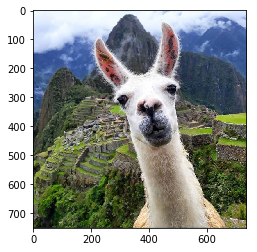


You are not a dog .. 
You are not a human .. 
Who are you ??


Hi there .. !!



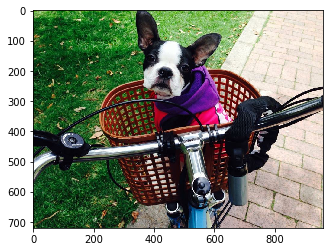


I don't know if you are a dog or a human, but you look like french bulldog .. !!


Hi there .. !!



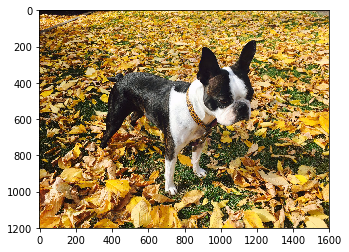


I don't know if you are a dog or a human, but you look like boston terrier .. !!


Hi there .. !!



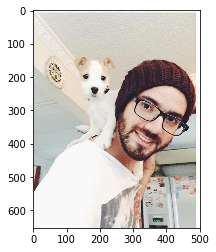


I don't know if you are a dog or a human, but you look like chihuahua .. !!


Hi there .. !!



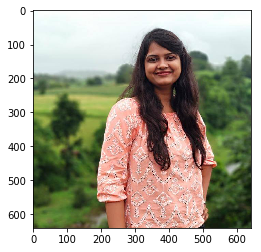


I know you are not a dog, but you look like english springer spaniel .. !!


Hi there .. !!



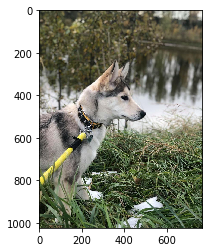


You must be alaskan malamute .. !!


Hi there .. !!



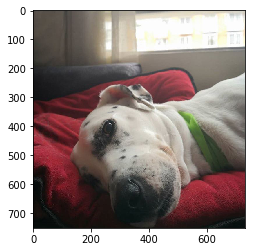


You must be dalmatian .. !!


Hi there .. !!



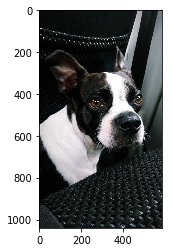


You are not a dog .. 
You are not a human .. 
Who are you ??


Hi there .. !!



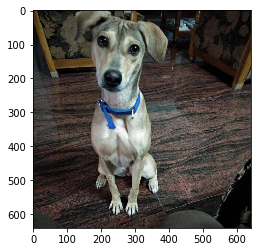


You must be italian greyhound .. !!


Hi there .. !!



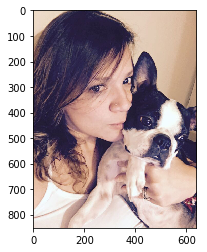


You must be boston terrier .. !!


Hi there .. !!



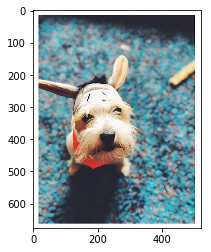


You must be silky terrier .. !!


Hi there .. !!



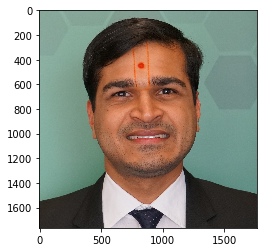


I know you are not a dog, but you look like beagle .. !!


In [220]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

all_files = np.array(glob("step7_testing/*"))

for img_path in all_files:
    predict_dog_breed(img_path)